<a href="https://colab.research.google.com/github/MINED30/MODELING/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [240]:
batch_size = 128

num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_ds = torchvision.datasets.CIFAR10(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="data/", train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size)

Files already downloaded and verified


In [243]:
def imshow(img,label,pltshow=False):    # unnormalize
    npimg = img.numpy()
    plt.title(label)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if pltshow:
      plt.show()

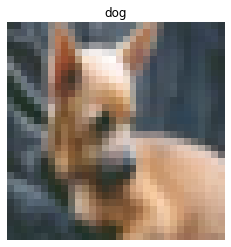

In [249]:
for images, labels in train_loader:
    imshow(images[0],classes[labels[0].item()],True)
    break

# Build Model

## Before Encoder

### Linear Projection of Flattened Pathes

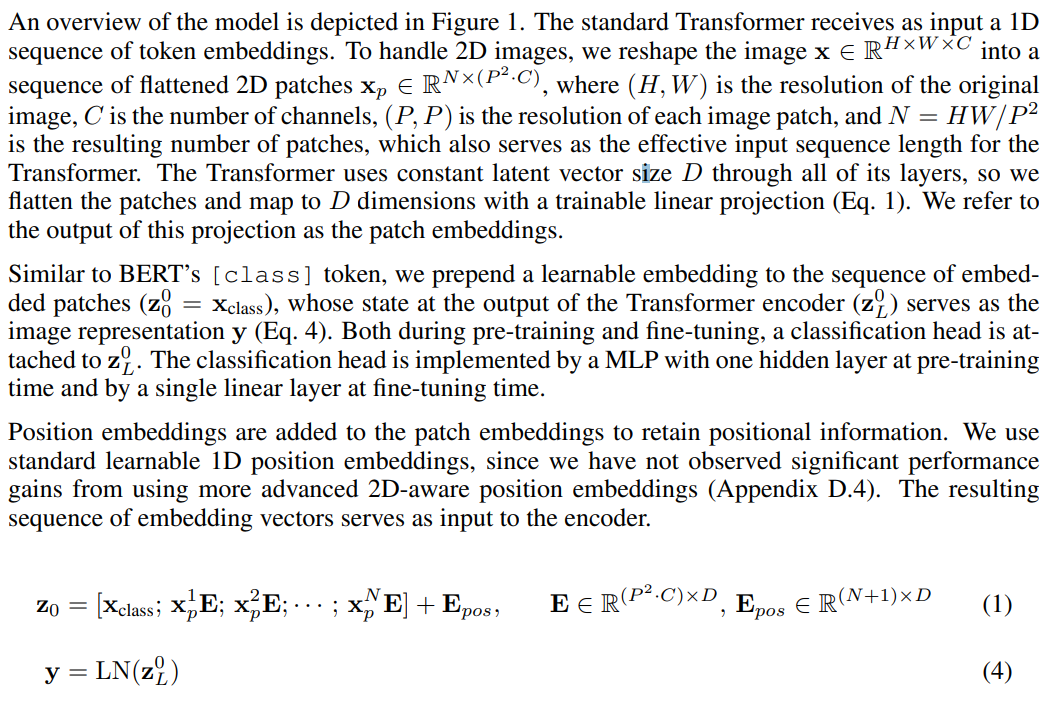

$(H, W, C) -> (N,P^2*C)$

$(32,32,3) -> (64,4^2*3)==(16,48)$


In [277]:
class PatchEmbedding(nn.Module):
  def __init__(self, 
               batch_size=128,
               height:int=32, 
               width:int=32, 
               n_channel:int=3, 
               patch_size:int=4,
               emb_size:int=768):
    super().__init__()
    self.height = height
    self.width = width
    self.n_channel = n_channel

    self.patch_size = patch_size
    self.n_patches = int((height*width)/(patch_size**2)) # N = HW/P^2

    self.emb_size = emb_size
    self.linear_projection = nn.Linear((patch_size**2)*n_channel, emb_size)

    self.cls_token = nn.Parameter(data=torch.randn(1,1, emb_size), requires_grad=True).repeat(batch_size,1,1)
    self.positions = nn.Parameter(data=torch.randn(self.n_patches + 1, emb_size), requires_grad=True)

  def forward(self,inputs):
    patches = self.extract_patches(inputs)  # (B, N, C, P, P) == (128, 64, 3, 4, 4)
    # print(patches.shape)
    flattened_patches = patches.flatten(2)  # (B, N, C*P^2) == (128, 64, 48)
    # print(flattened_patches.shape)
    projection = self.linear_projection(flattened_patches)  # (B, N, emb_size) == (128, 64, 768)
    # print("projection :\t",projection.shape)

    cls_tokens = self.cls_token # CLS : (B, 1, emb_size) == (128, 1, 768)
    # print("cls token :\t",cls_tokens.shape)

    output = torch.cat([cls_tokens,projection],dim=1)
    output += self.positions  # OUT : (B, N+1, emb_size) == (128, 65, 768)
    # print("output :\t",output.shape)
    return output

  def extract_patches(self, img):
    # input image : B, C, H, W
    patch_fold_H = img.unfold(2,self.patch_size,self.patch_size)  # patch_fold_H : (B, C, H/Patchsize, W, Patchsize_H)
    patches = patch_fold_H.unfold(3, self.patch_size,self.patch_size) # patch_fold_H : (B, C, H/Patchsize(N_H), W/Patchsize(N_W), Patchsize_H, Patchsize_W)
    patches = patches.permute(0,2,3,1,4,5) # patches : (B, N_H, N_W, C, Patchsize_H, Patchsize_W)
    patches = patches.reshape(-1,self.n_patches,self.n_channel, self.patch_size,self.patch_size) # patches : (B, N, Patchsize_H, Patchsize_W)
    return patches


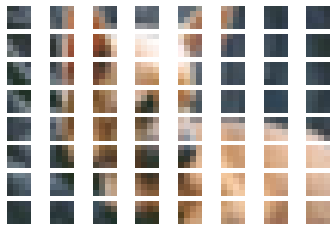

torch.Size([128, 65, 768])

In [278]:
pe = PatchEmbedding()
patches = pe.extract_patches(images[0:1])[0]
for i in range(64):
  plt.subplot(8,8,i+1)
  imshow(patches[i],None)
plt.show()

pe(images).shape

## Encoder

### LN(Layer Normalization)

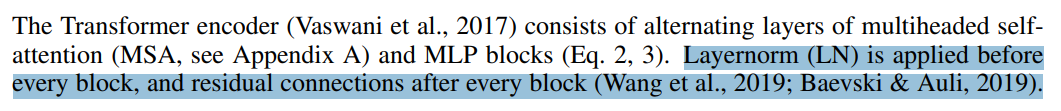

Layer normalization (Ba et al., 2016).

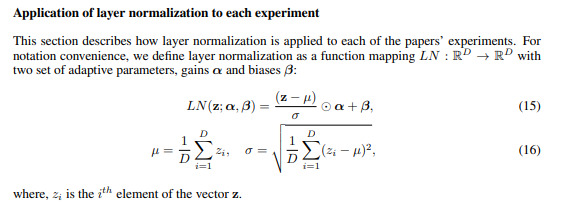

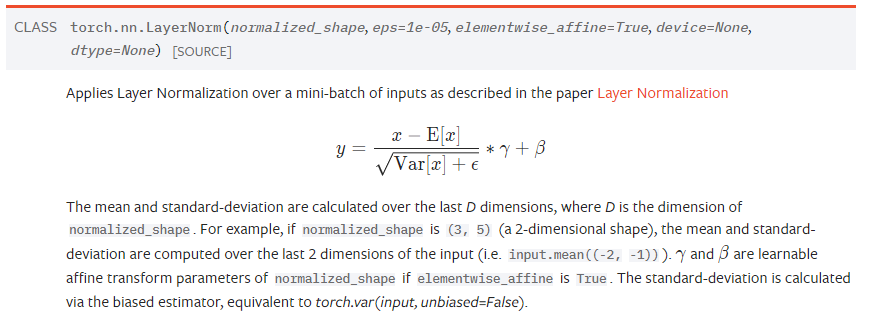

In [ ]:
# class LayerNormalization(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.ln = nn.LayerNorm()

#   def forward(self,inputs):
#     return ln(inputs)

### MSA(Multihead Self Attention)

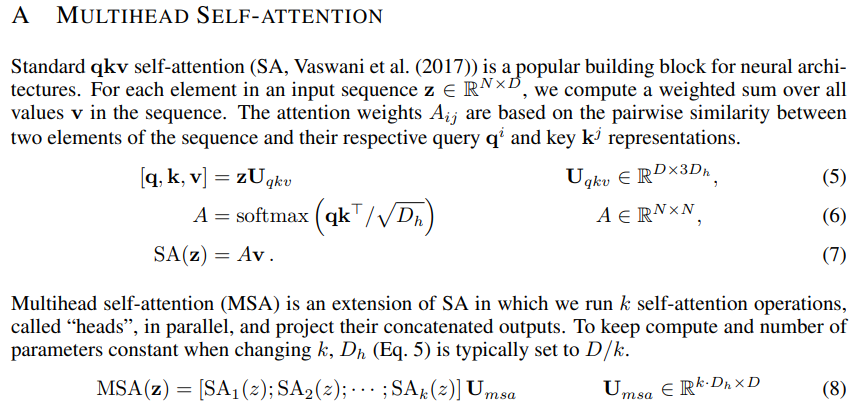

In [283]:
class MSA(nn.Module):
  def __init__(self, emb_size=768, num_heads=8, return_attn_output_weights=False, **kwargs):
    super().__init__()

    self.multihead_attention = nn.MultiheadAttention(emb_size, num_heads, batch_first=True)
    self.query = nn.Linear(emb_size,emb_size)
    self.key = nn.Linear(emb_size,emb_size)
    self.value = nn.Linear(emb_size,emb_size)
    self.return_attn_output_weights = return_attn_output_weights

  def forward(self,inputs):
    inputs = nn.LayerNorm(inputs.shape)(inputs)
    # print(inputs.shape)
    q = self.query(inputs)  # (B, N+1, emb_size) == (128, 65, 768)
    k = self.key(inputs)    # (B, N+1, emb_size) == (128, 65, 768)
    v = self.value(inputs)  # (B, N+1, emb_size) == (128, 65, 768)
    # print(q.shape)

    attn_output, attn_output_weights = self.multihead_attention(q,k,v)
    if self.return_attn_output_weights:
      # attn_output : (B, N+1, emb_size)==(128, 65, 768)
      # attn_output_weights : (B, N+1, N+1)==(128, 65, 65)
      return attn_output,attn_output_weights
    else:
      return attn_output
shape_test = MSA(return_attn_output_weights=True)(pe(images))
print(shape_test[0].shape)
print(shape_test[1].shape)

torch.Size([128, 65, 768])
torch.Size([128, 65, 65])


### MultiLayerPerceptron

In [284]:
class MLP(nn.Module):
  def __init__(self,emb_size=768, mlp_size=3072, **kwargs):
    super().__init__()
    self.mlp_in = nn.Linear(emb_size, mlp_size)
    self.gelu = nn.GELU()
    self.mlp_out = nn.Linear(mlp_size, emb_size)
  def forward(self,inputs):
    inputs = nn.LayerNorm(inputs.shape)(inputs)
    x = self.mlp_in(inputs)
    x = self.gelu(x)
    output = self.mlp_out(x)
    return output

MLP()(MSA()(pe(images))).shape

torch.Size([128, 65, 768])

### Transformer Encoder

In [285]:
config={
  "batch_size" : 16,
  "num_classes" : 10,
  "batch_size" : 128,
  "height" : 32,
  "width" : 32,
  "n_channel" : 3,
  "patch_size" : 4,
  "emb_size" : 768,
  "num_heads" : 8,
  "mlp_size" : 3072
}

In [289]:
class VisionTransformerEncdoer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.msa = MSA(**config)
        self.mlp = MLP(**config)

    def forward(self,inputs):
        mas_residual = inputs
        msa_output = self.msa(inputs)
        msa_output += mas_residual

        mlp_residual = msa_output
        mlp_output = self.msa(msa_output)
        mlp_output += mlp_residual
        return mlp_output

In [290]:
VisionTransformerEncdoer(config)(pe(images)).shape

torch.Size([128, 65, 768])

## After Encoder

### MLP Head

In [297]:
class MLPHead(nn.Module):
  def __init__(self,emb_size=768,num_classes=10):
    super().__init__()
    self.classifier = nn.Linear(emb_size, num_classes)

  def forward(self, inputs):
    print(inputs.shape)
    x = inputs[:,0,:]
    x = nn.LayerNorm(x.shape)(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return x
    
x = MLPHead()(VisionTransformerEncdoer(config)(pe(images)))

torch.Size([128, 65, 768])
torch.Size([128, 768])
torch.Size([128, 10])


In [298]:
x

tensor([[-0.7009,  0.1536, -0.1481,  ..., -0.2741, -0.8959, -0.4574],
        [-0.6965,  0.1478, -0.1502,  ..., -0.2746, -0.9012, -0.4612],
        [-0.7149,  0.1596, -0.1427,  ..., -0.2752, -0.8865, -0.4600],
        ...,
        [-0.6968,  0.1498, -0.1539,  ..., -0.2696, -0.9050, -0.4600],
        [-0.7092,  0.1562, -0.1468,  ..., -0.2803, -0.8854, -0.4610],
        [-0.7035,  0.1503, -0.1518,  ..., -0.2798, -0.8954, -0.4600]],
       grad_fn=<AddmmBackward>)

# Train

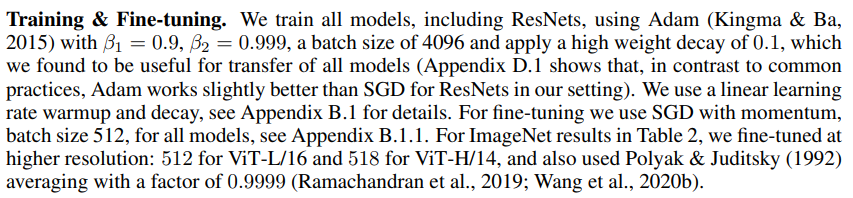

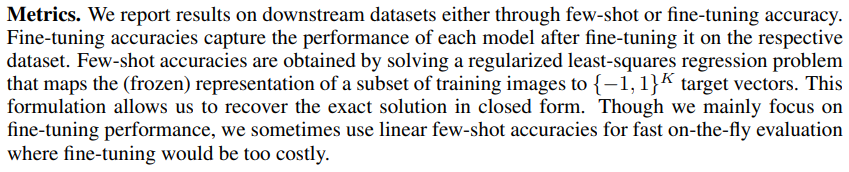